<a href="https://colab.research.google.com/github/pceg/heart_disease_prediction/blob/main/heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Opis danych:**

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
7. restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. num: diagnosis of heart disease (angiographic disease status)

# Importy

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy.stats import loguniform
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from scipy.stats import uniform


# Wczytanie danych

In [ ]:
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]
df = pd.read_csv("/content/sample_data/processed.cleveland.data", header=None, names=columns, na_values="?")


# Wstępna analiza

Zrozumienie danych

In [ ]:
df.shape

(303, 14)

In [ ]:
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [ ]:
print(df.dtypes)

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object


In [ ]:
# wyświetl gdzie brakujące dane
print(df.isnull().sum()[df.isnull().sum() > 0])

ca      4
thal    2
dtype: int64


In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


## Usuwanie danych brakujących

Znajdowanie wierszy, które mają brakujące dane i podjęcie decyzji czy dane wiersze usunąć czy uzupełnić brakujące elementy wartościami

In [ ]:
df.replace("?", np.nan, inplace=True)

missing_rows = df[df.isna().any(axis=1)]

print(missing_rows.to_string())


      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  slope   ca  thal  num
87   53.0  0.0  3.0     128.0  216.0  0.0      2.0    115.0    0.0      0.0    1.0  0.0   NaN    0
166  52.0  1.0  3.0     138.0  223.0  0.0      0.0    169.0    0.0      0.0    1.0  NaN   3.0    0
192  43.0  1.0  4.0     132.0  247.0  1.0      2.0    143.0    1.0      0.1    2.0  NaN   7.0    1
266  52.0  1.0  4.0     128.0  204.0  1.0      0.0    156.0    1.0      1.0    2.0  0.0   NaN    2
287  58.0  1.0  2.0     125.0  220.0  0.0      0.0    144.0    0.0      0.4    2.0  NaN   7.0    0
302  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0    1.0  NaN   3.0    0


In [ ]:
df_cleaned = df.dropna()

print("Nowy rozmiar danych:", df_cleaned.shape)
print("Liczba brakujących wartości po czyszczeniu:", df_cleaned.isna().sum().sum())


Nowy rozmiar danych: (297, 14)
Liczba brakujących wartości po czyszczeniu: 0


In [ ]:
X = df_cleaned.drop(columns=["num"])  # cechy
y = df_cleaned["num"]  # etykiety (stadium choroby)


# EDA

Analiza "num"

In [ ]:
df_cleaned["num"].unique()

array([0, 2, 1, 3, 4])

num
0    160
1     54
2     35
3     35
4     13
Name: count, dtype: int64


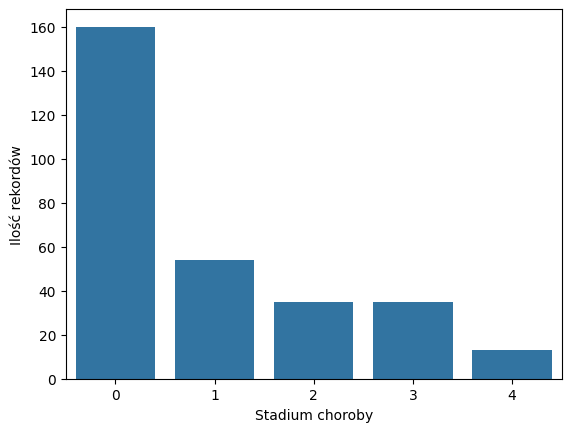

In [ ]:
sns.countplot(x=y)

plt.xlabel('Stadium choroby')
plt.ylabel('Ilość rekordów')

target_temp = df_cleaned.num.value_counts()

print(target_temp)

In [ ]:
for i in range(5):
  print(f"Class {i}: {str(round(target_temp[i]*100/303,2))}%")


Class 0: 52.81%
Class 1: 17.82%
Class 2: 11.55%
Class 3: 11.55%
Class 4: 4.29%


Analiza korelacji

In [ ]:
# analiza korelacji z etykietą "num"
print(df_cleaned.corr()["num"].abs().sort_values(ascending=False))

num         1.000000
ca          0.521178
thal        0.513377
oldpeak     0.501461
thalach     0.420639
cp          0.404248
exang       0.391613
slope       0.374689
sex         0.226797
age         0.222156
restecg     0.184136
trestbps    0.159620
chol        0.066448
fbs         0.049040
Name: num, dtype: float64


Większość kolumn jest umiarkowanie skorelowana z kolumną "num", ale 'fbs' i 'chol' są mało skorelowane.

Cecha "sex"

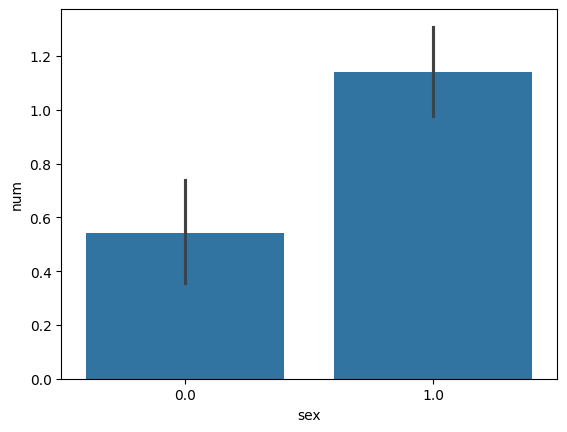

In [ ]:
sns.barplot(x="sex", y="num", data=df_cleaned) # barplot - średnia wartość
plt.show()

Chest pain (cp)

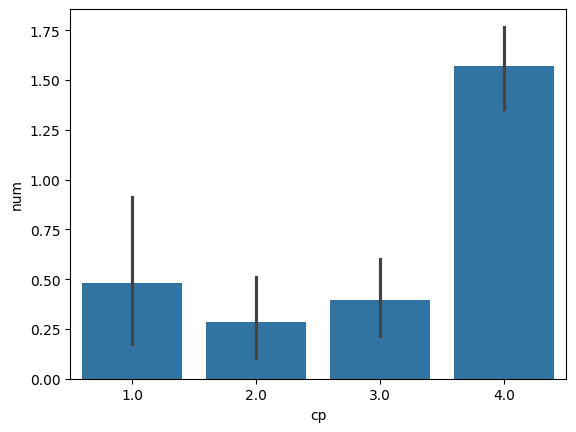

In [ ]:
sns.barplot(x="cp", y="num", data=df_cleaned)
plt.show()

Różne rozkłady

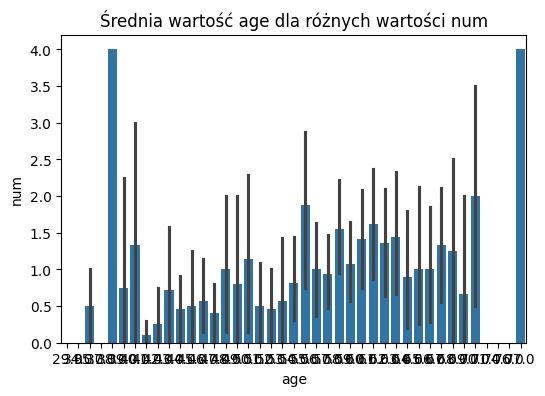

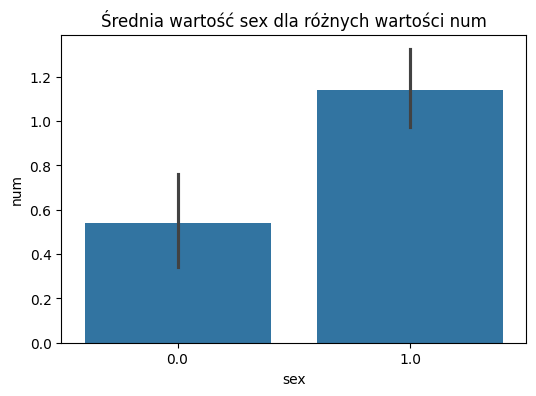

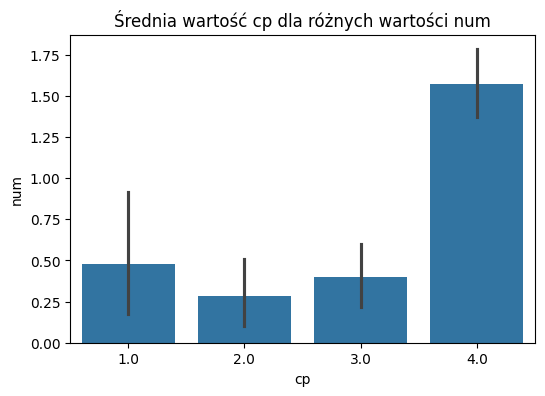

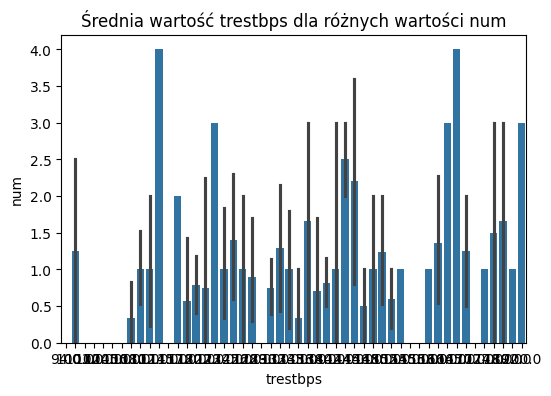

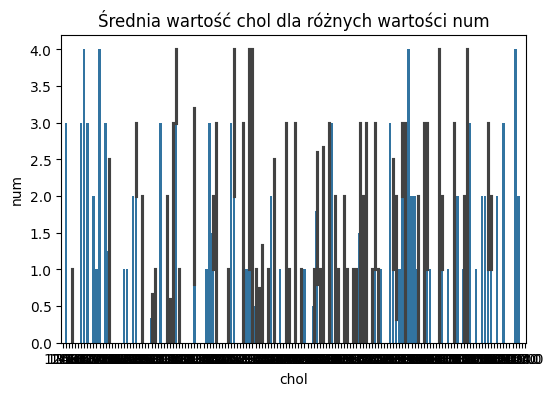

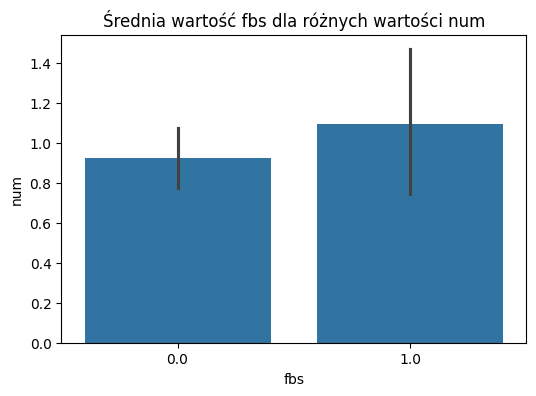

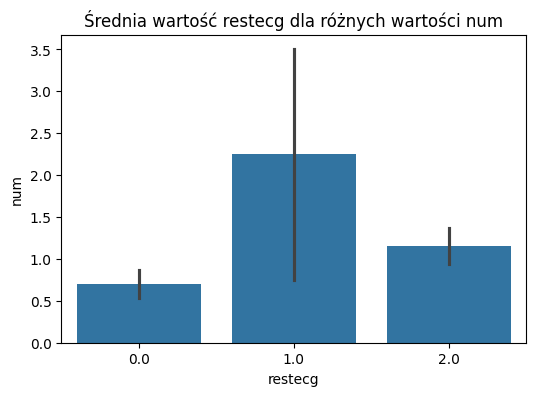

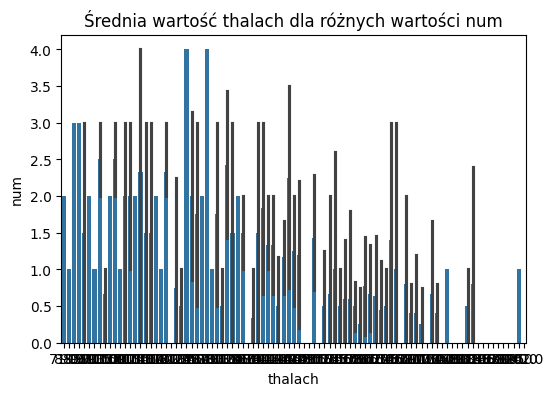

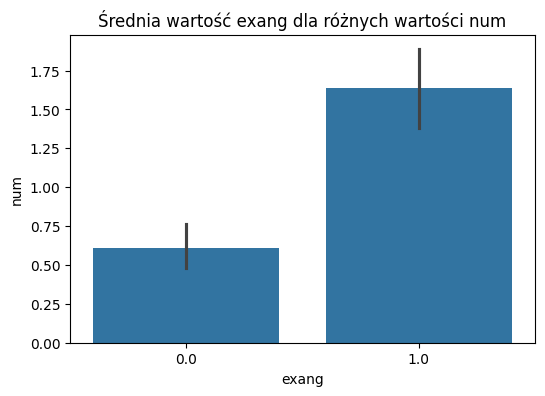

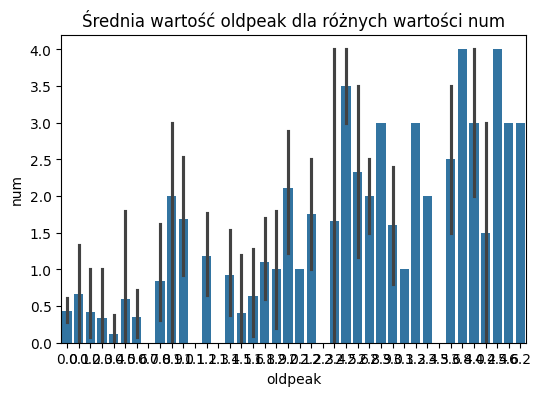

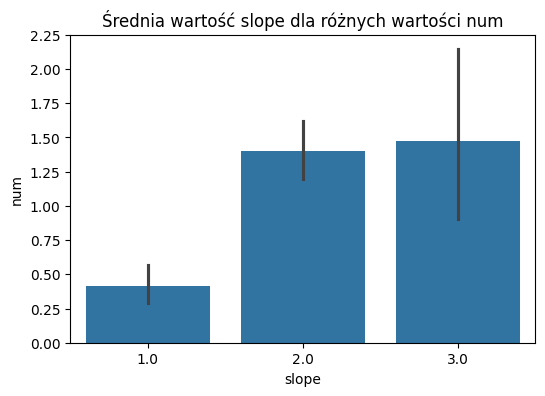

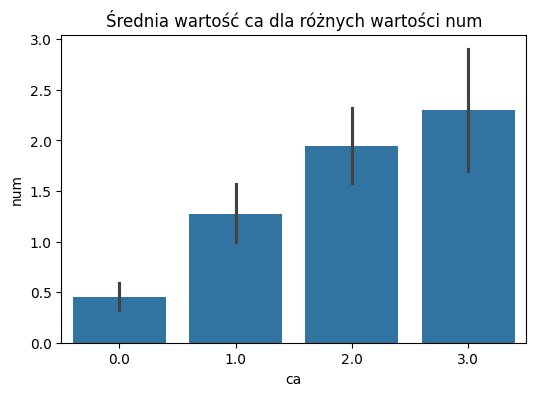

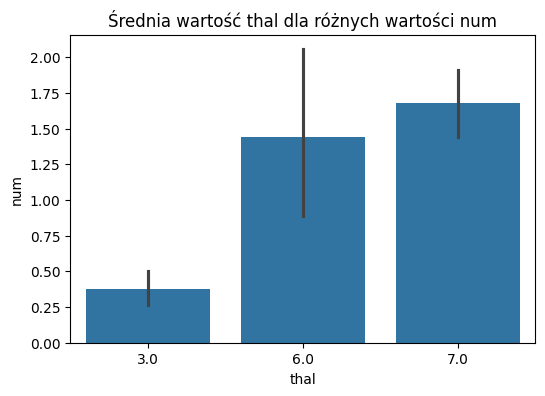

In [ ]:
target_col = df_cleaned.columns[-1]

for col in df_cleaned.columns[:-1]:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=df_cleaned[col], y=df_cleaned[target_col])
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f"Średnia wartość {col} dla różnych wartości {target_col}")
    plt.show()


# Dane eksperymentalne

In [ ]:
threshold = 0.3

correlations = df_cleaned.corr()["num"].abs().sort_values(ascending=False)

# Wybór cech, które przekraczają próg
selected_features = correlations[correlations > threshold].index.tolist()
selected_features.remove("num")

X_exp = df_cleaned[selected_features]
y_exp = df_cleaned["num"]

print("Wybrane cechy:", selected_features)


Wybrane cechy: ['ca', 'thal', 'oldpeak', 'thalach', 'cp', 'exang', 'slope']


In [ ]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.25, random_state=42)

# Podział na dane treningowe i testowe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train.shape

(222, 13)

In [ ]:
X_test.shape

(75, 13)

In [ ]:
y_train.shape

(222,)

In [ ]:
y_test.shape

(75,)

# Budowanie klasyfikatorów

Funkcja która pokazuje raport z oceny jakości modelu

In [ ]:
# zwraca accuracy na zbiorze testowym
def show_classification_report(search, xtest, ytest, xtrain, ytrain):
  print("Najlepsze parametry:", search.best_params_)
  best_model = search.best_estimator_
  y_pred = best_model.predict(xtest)
  print(f"Dokładność na zbiorze treningowym: {best_model.score(xtrain, ytrain)}")
  print(f"Dokładność na zbiorze testowym: {best_model.score(xtest, ytest)}")
  print("\nRaport klasyfikacji:")
  print(classification_report(ytest, y_pred))
  return best_model.score(xtest, ytest)

## DT

Wersja 1

In [ ]:
param_dist_dt = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random']
}

dt = DecisionTreeClassifier(random_state=42)


start_time = time.time()

random_search_dt = RandomizedSearchCV(dt, param_distributions=param_dist_dt, n_iter=100, cv=7, random_state=42, n_jobs=-1)
random_search_dt.fit(X_train, y_train)

end_time = time.time()
elapsed_time_dt = end_time - start_time

acc_dt = show_classification_report(random_search_dt, X_test, y_test, X_train, y_train)

print(f"Czas trwania procesu: {elapsed_time_dt:.2f} sekund")

Najlepsze parametry: {'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 19, 'min_samples_split': 16, 'splitter': 'random'}
Dokładność na zbiorze treningowym: 0.5900900900900901
Dokładność na zbiorze testowym: 0.6133333333333333

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        42
           1       0.00      0.00      0.00        13
           2       0.28      0.62      0.38         8
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3

    accuracy                           0.61        75
   macro avg       0.22      0.32      0.25        75
weighted avg       0.48      0.61      0.53        75

Czas trwania procesu: 2.80 sekund


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Wizualizacja drzewa**

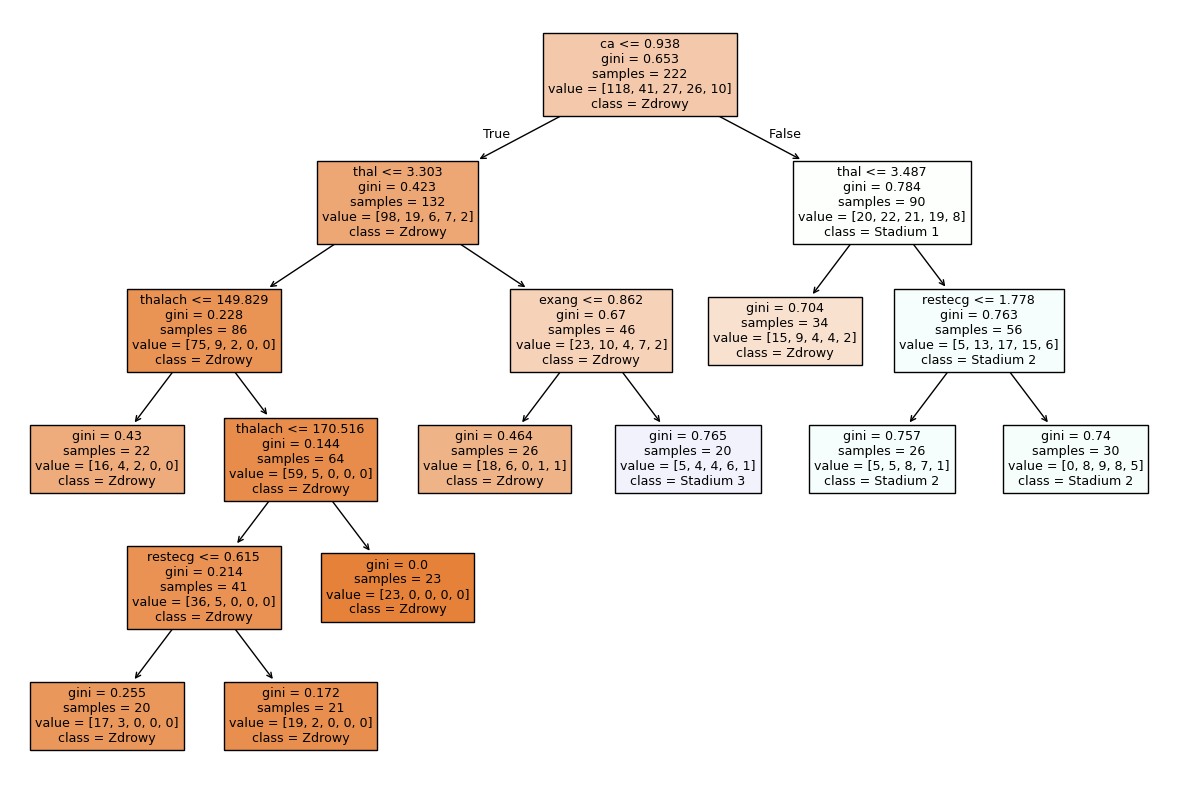

In [ ]:
# Wykres drzewa decyzyjnego bez smote
plt.figure(figsize=(15, 10))
plot_tree(random_search_dt.best_estimator_, filled=True, feature_names=X_train.columns, class_names=['Zdrowy', 'Stadium 1', 'Stadium 2', 'Stadium 3', 'Stadium 4'])
plt.show()


## RF

Wersja 1

In [ ]:
param_dist_rf = {
    'n_estimators': randint(200, 300),
    'max_features': ['log2', None],
    'max_depth': randint(80, 100),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(10, 30),
}

rf = RandomForestClassifier(random_state=42)

start_time = time.time()

random_search_rf = RandomizedSearchCV(rf, param_distributions=param_dist_rf, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

end_time = time.time()
elapsed_time_rf = end_time - start_time

acc_rf = show_classification_report(random_search_rf, X_test, y_test, X_train, y_train)

print(f"Czas trwania procesu: {elapsed_time_rf:.2f} sekund")


Najlepsze parametry: {'max_depth': 99, 'max_features': None, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 250}
Dokładność na zbiorze treningowym: 0.6756756756756757
Dokładność na zbiorze testowym: 0.6133333333333333

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        42
           1       0.20      0.08      0.11        13
           2       0.25      0.25      0.25         8
           3       0.25      0.11      0.15         9
           4       0.00      0.00      0.00         3

    accuracy                           0.61        75
   macro avg       0.28      0.29      0.27        75
weighted avg       0.50      0.61      0.53        75

Czas trwania procesu: 119.21 sekund


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### RF z danymi eksperymentalnymi (selekcja cech za pomocą korelacji)

In [ ]:
start_time = time.time()
random_search_rf.fit(X_train_exp, y_train_exp)

end_time = time.time()
elapsed_time_rf_exp = end_time - start_time

acc_rf_exp = show_classification_report(random_search_rf, X_test_exp, y_test_exp, X_train_exp, y_train_exp)
print(f"Czas trwania procesu: {elapsed_time_rf_exp:.2f} sekund")


Najlepsze parametry: {'max_depth': 86, 'max_features': None, 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 208}
Dokładność na zbiorze treningowym: 0.6171171171171171
Dokładność na zbiorze testowym: 0.6

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        42
           1       0.00      0.00      0.00        13
           2       0.22      0.25      0.24         8
           3       0.50      0.11      0.18         9
           4       0.00      0.00      0.00         3

    accuracy                           0.60        75
   macro avg       0.28      0.27      0.24        75
weighted avg       0.46      0.60      0.49        75

Czas trwania procesu: 134.40 sekund


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## SVM

Wersja 1

In [ ]:
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
}

svm = SVC(random_state=42)

start_time = time.time()

grid_search_svm = GridSearchCV(svm, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

end_time = time.time()
elapsed_time_svm = end_time - start_time

acc_svm = show_classification_report(grid_search_svm, X_test, y_test, X_train, y_train)
print(f"Czas trwania procesu: {elapsed_time_svm:.2f} sekund")


Najlepsze parametry: {'C': 100, 'kernel': 'linear'}
Dokładność na zbiorze treningowym: 0.6891891891891891
Dokładność na zbiorze testowym: 0.6

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        42
           1       0.25      0.15      0.19        13
           2       0.17      0.12      0.14         8
           3       0.14      0.11      0.12         9
           4       0.00      0.00      0.00         3

    accuracy                           0.60        75
   macro avg       0.27      0.27      0.27        75
weighted avg       0.53      0.60      0.56        75

Czas trwania procesu: 151.37 sekund


## Bayes

In [ ]:
param_dist_gnb = {
    'var_smoothing': loguniform(1e-9, 1e-5)
}

gnb = GaussianNB()

start_time = time.time()

random_search_gnb = RandomizedSearchCV(gnb, param_distributions=param_dist_gnb, n_iter=200, cv=5, random_state=42, n_jobs=-1)
random_search_gnb.fit(X_train, y_train)

end_time = time.time()
elapsed_time_bayes = end_time - start_time

acc_gnb = show_classification_report(random_search_gnb, X_test, y_test, X_train, y_train)

print(f"Czas trwania procesu: {elapsed_time_bayes:.2f} sekund")


Najlepsze parametry: {'var_smoothing': 2.915443189153751e-06}
Dokładność na zbiorze treningowym: 0.6486486486486487
Dokładność na zbiorze testowym: 0.6

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.29      0.31      0.30        13
           2       0.25      0.25      0.25         8
           3       0.00      0.00      0.00         9
           4       0.14      0.33      0.20         3

    accuracy                           0.60        75
   macro avg       0.32      0.36      0.33        75
weighted avg       0.59      0.60      0.59        75

Czas trwania procesu: 4.92 sekund


## Sieć neuronowa

In [ ]:
param_dist_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': uniform(1e-5, 1e-2),
    'learning_rate': ['constant'],
    'max_iter': [200],
}

mlp = MLPClassifier(random_state=42)

start_time = time.time()

random_search_mlp = RandomizedSearchCV(mlp, param_distributions=param_dist_mlp, n_iter=50, cv=3, random_state=42, n_jobs=-1)
random_search_mlp.fit(X_train, y_train)

end_time = time.time()
elapsed_time_mlp = end_time - start_time

y_pred = random_search_mlp.best_estimator_.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred)
precision_mlp = precision_score(y_test, y_pred, average='weighted')
recall_mlp = recall_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f"Najlepsze parametry: {random_search_mlp.best_params_}")
print(f"Dokładność na zbiorze testowym: {acc_mlp:.4f}")
print(f"Precyzja na zbiorze testowym: {precision_mlp:.4f}")
print(f"Czułość na zbiorze testowym: {recall_mlp:.4f}")
print(f"Czas trwania procesu: {elapsed_time_mlp:.2f} sekund")
print("\nRaport klasyfikacji:")
print(report)


Najlepsze parametry: {'activation': 'relu', 'alpha': 0.007090725777960455, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Dokładność na zbiorze testowym: 0.6267
Precyzja na zbiorze testowym: 0.5977
Czułość na zbiorze testowym: 0.6267
Czas trwania procesu: 22.40 sekund

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        42
           1       0.36      0.38      0.37        13
           2       0.29      0.25      0.27         8
           3       0.17      0.11      0.13         9
           4       0.00      0.00      0.00         3

    accuracy                           0.63        75
   macro avg       0.34      0.33      0.33        75
weighted avg       0.60      0.63      0.61        75



# Podsumowanie

In [ ]:
results = {
    'Klasyfikator': ['Drzewo decyzyjne', 'Random Forest', 'SVM', 'Naive Bayes', 'Sieć neuronowa'],
    'Dokładność': [acc_dt, acc_rf, acc_svm, acc_gnb, acc_mlp],
    'Czas trwania [s]': [elapsed_time_dt, elapsed_time_rf, elapsed_time_svm, elapsed_time_bayes, elapsed_time_mlp]
}

df_results = pd.DataFrame(results)

df_results_sorted = df_results.sort_values(by='Dokładność', ascending=False)

print(df_results_sorted)

       Klasyfikator  Dokładność  Czas trwania [s]
4    Sieć neuronowa    0.626667         22.398144
0  Drzewo decyzyjne    0.613333          2.799665
1     Random Forest    0.613333        119.213688
2               SVM    0.600000        151.367253
3       Naive Bayes    0.600000          4.919941
